In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgbm
from pathlib import Path
from ilmart import IlmartDistill
import numpy as np
import seaborn as sns

In [2]:
BASE_DIR = Path("../../ilmart-data")

In [3]:
model_file = BASE_DIR / "ft/web30k/contrib/inter_contrib.lgbm"
ilmart_model = lgbm.Booster(model_file=model_file)

In [5]:
ilmart_model_distilled = IlmartDistill(ilmart_model)

In [6]:
feat_imp = list(ilmart_model_distilled.expected_contribution().items())

In [7]:
feat_imp.sort(key=lambda x: x[1], reverse=True)
feat_imp

[((133,), 1.0595293487181219),
 ((11,), 0.3218965115336256),
 ((7,), 0.3218775413266739),
 ((128,), 0.320351962313857),
 ((26, 122), 0.29908061012393344),
 ((13,), 0.2803266196384694),
 ((132,), 0.27616166432580525),
 ((128, 132), 0.271990036334931),
 ((2,), 0.26979678991017125),
 ((29,), 0.2580737126277133),
 ((133, 134), 0.2518723864454929),
 ((11, 125), 0.24467948983911056),
 ((12,), 0.24394765525273648),
 ((134,), 0.2339308466693568),
 ((13, 125), 0.22413971021441137),
 ((7, 29), 0.21543546024996027),
 ((12, 26), 0.21001881990916915),
 ((2, 107), 0.20422971884928787),
 ((104, 133), 0.19731951858719404),
 ((114,), 0.19108843414672197),
 ((53,), 0.18279162817600497),
 ((36,), 0.17895158911093545),
 ((122, 133), 0.16844242037633542),
 ((126,), 0.16838089543368495),
 ((131,), 0.1511731499203408),
 ((53, 54), 0.14630432903387075),
 ((11, 104), 0.14091738289769756),
 ((129,), 0.13811223705660747),
 ((108, 134), 0.13768858050815402),
 ((48,), 0.1307510752503022),
 ((64,), 0.12956785440783

In [8]:
feats_label = {
    2: "Covered Query Term Number - Title",
    7: "Covered Query Term Ratio - Title",
    11: "Stream Length - Anchor",
    12: "Stream Length - Title",
    13: "Stream Length - URL",
    26: "Min of Term Frequency - Anchor",
    29: "Min of Term Frequency - Whole Document",
    107: "BM25 - Title",
    122: "LMIR.JM - title",
    125: "Number of slash in URL",
    128: "Outlink Number",
    132: "QualityScore2",
    133: "Query-URL Click Count",
    134: "URL Click Count"
}

## Create plot for the main effects

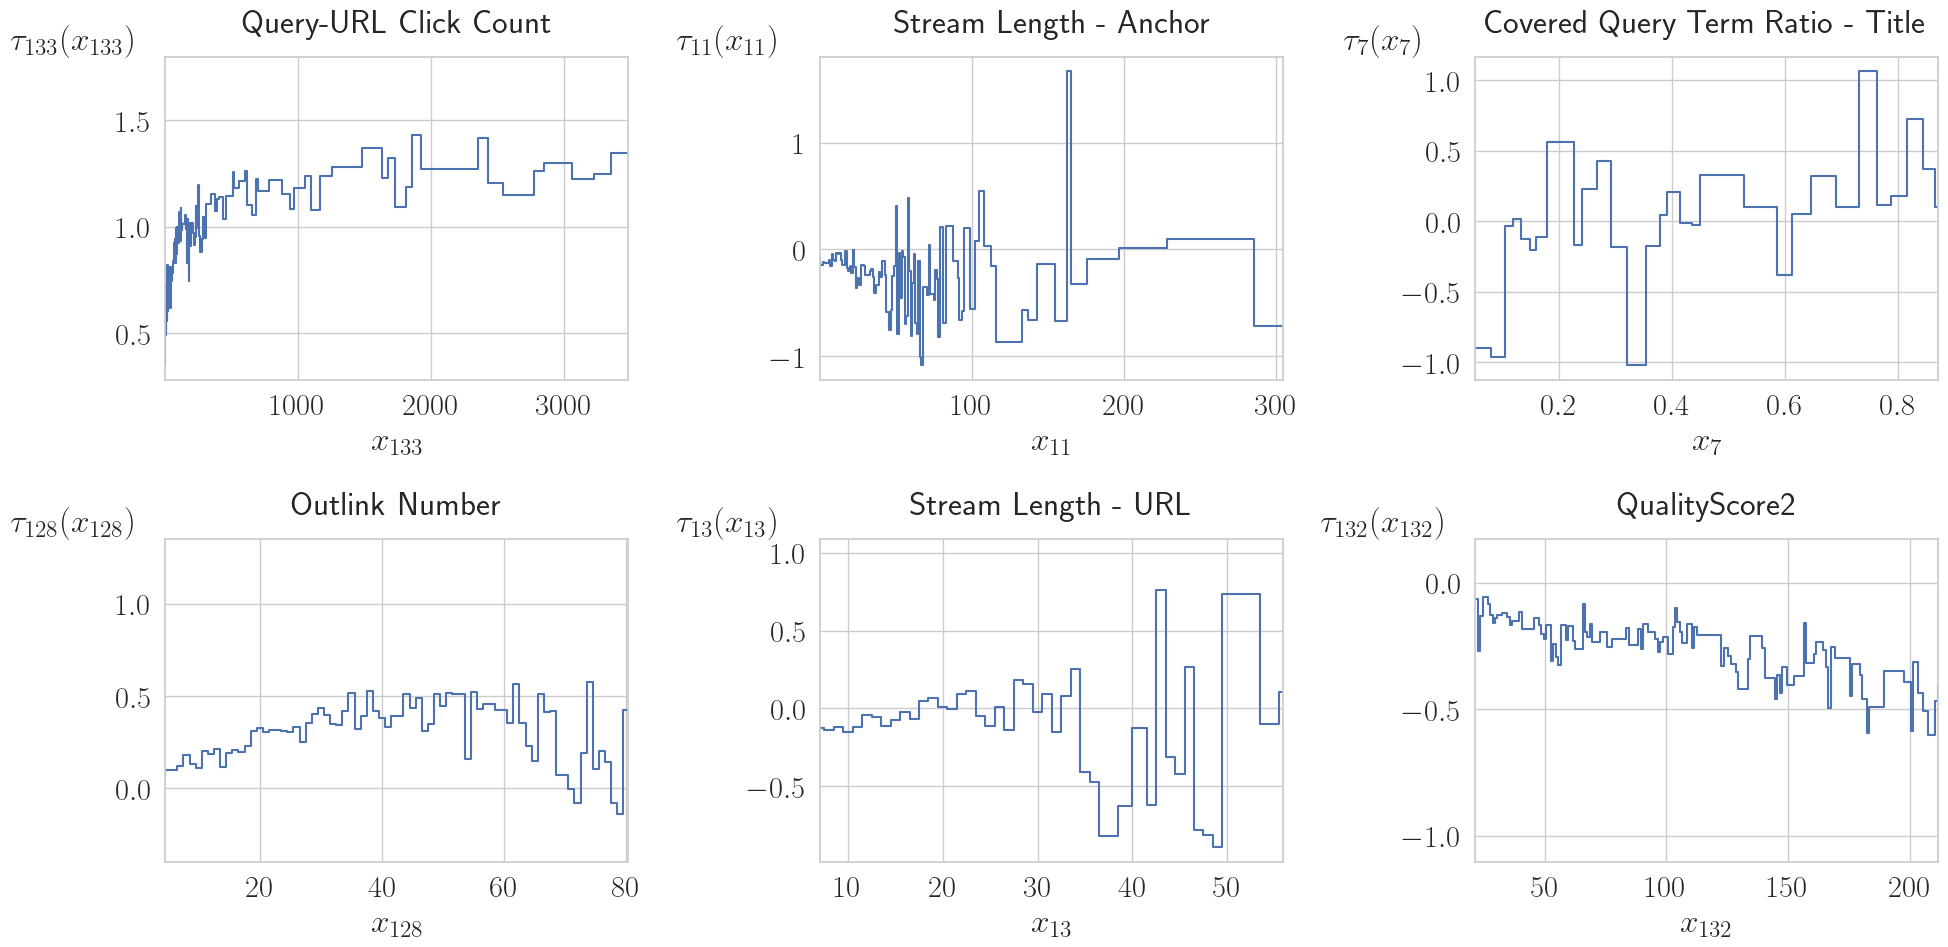

In [9]:
sns.set_theme(font_scale=2, style="whitegrid", rc={'text.usetex': True})
x_lims = [(0.01, 0.8), (0.01, 0.99), (0.05, 0.95), (0.05, 0.8),
          (0.1, 0.9), (0.1, 0.9), (0.1, 0.8), (0.1, 0.9)]
fig, axs = plt.subplots(2, 3, figsize=(20, 10), layout='tight')

feat_imp_only_main_effect = [(feat, imp) for feat, imp in feat_imp if len(feat) == 1]
for i, (feat, imp) in enumerate(feat_imp_only_main_effect[:6]):
    if len(feat) > 1:
        print("Huston, we have a problem")
        print(feat)
        continue
    feat = int(feat[0])
    current_ax = axs[i // 3, i % 3]
    x = ilmart_model_distilled.splitting_values[feat]
    y = np.append(ilmart_model_distilled.hist[(feat,)], ilmart_model_distilled.hist[(feat,)][-1])
    sns.lineplot(x=x, y=y, drawstyle='steps-pre', ax=current_ax)
    current_ax.set_ylabel(fr"$\tau_{{{feat}}}(x_{{{feat}}})$", rotation=0)
    current_ax.yaxis.set_label_coords(-0.2, 1)
    x_limi_inf = np.quantile(x, x_lims[i][0])
    x_limi_sup = np.quantile(x, x_lims[i][1])
    current_ax.set_xlim(x_limi_inf, x_limi_sup)
    current_ax.set_title(f"{feats_label[feat]}",  y=1.05)
    current_ax.set_xlabel(fr"$x_{{{feat}}}$")
plt.savefig("plots/global_explanation_main.pdf", bbox_inches='tight')

## Create plot for the interaction effects

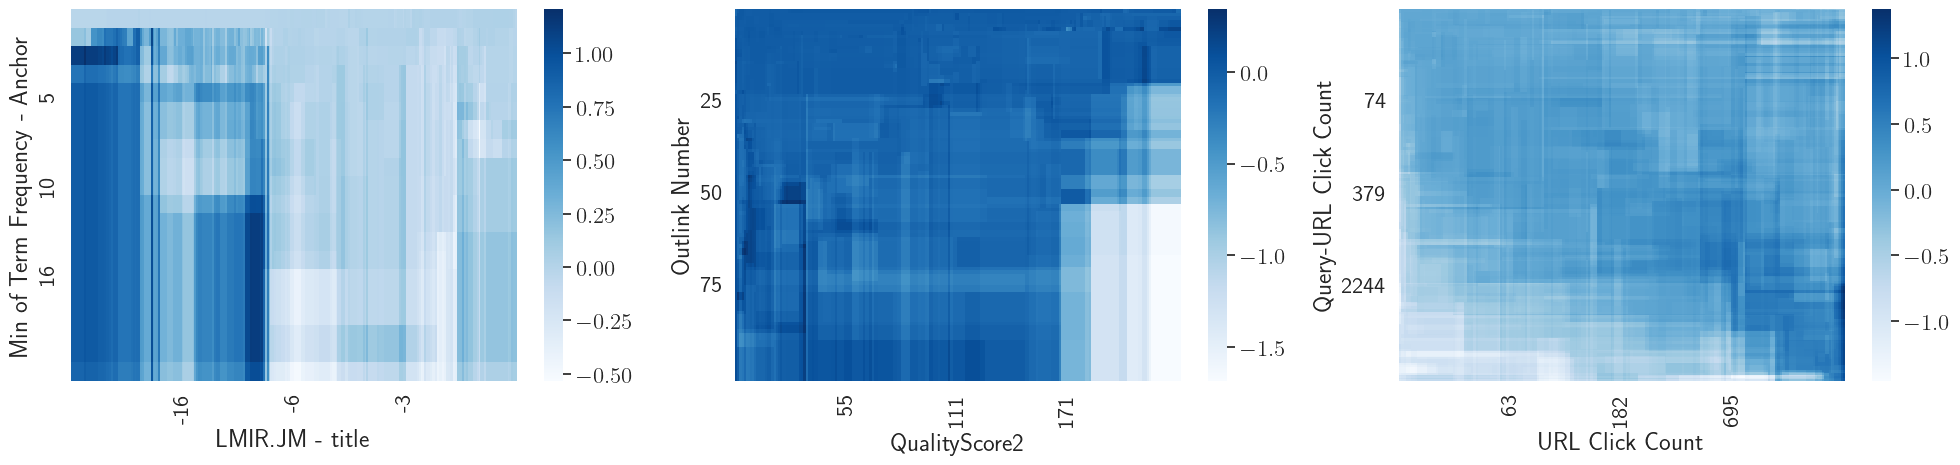

In [10]:
sns.set_theme(font_scale=1.5, style="whitegrid", rc={'text.usetex': True})
x_lims = [(0.01, 0.8), (0.01, 0.99), (0.05, 0.95), (0.05, 0.8), ]
fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='tight')

feat_imp_only_inter_effect = [(feat, imp) for feat, imp in feat_imp if len(feat) == 2]
for i, (feat, imp) in enumerate(feat_imp_only_inter_effect[:3]):
    if len(feat) < 2:
        print("Huston, we have a problem")
        print(feat)
        continue
    feat1 = int(feat[0])
    feat2 = int(feat[1])
    current_ax = axs[i % 3]
    values_matrix = ilmart_model_distilled.hist[(feat1, feat2)]
    splits_feat1 = ilmart_model_distilled.splitting_values[feat1]
    splits_feat2 = ilmart_model_distilled.splitting_values[feat2]
    sns.heatmap(values_matrix,
                cmap="Blues",
                ax=current_ax)
    #current_ax.set_ylabel(fr"$x_{{{feat1}}}$    {feats_label[feat1]}")
    current_ax.set_ylabel(fr"{feats_label[feat1]}")
    #current_ax.set_xlabel(fr"$x_{{{feat2}}}$    {feats_label[feat2]}")
    current_ax.set_xlabel(fr"{feats_label[feat2]}")

    crop = np.array(range(25, 100, 25)) / 100
    
    reduced_yticks = np.quantile(range(values_matrix.shape[0]), crop)
    reduced_ylabels = np.quantile(splits_feat1, crop)

    reduced_xticks = np.quantile(range(values_matrix.shape[1]), crop)
    reduced_xlabels = np.quantile(splits_feat2, crop)
    
    
    current_ax.set_yticks(ticks=reduced_yticks, labels=[f"{elem:.0f}" for elem in reduced_ylabels])
    current_ax.set_xticks(ticks=reduced_xticks,labels=[f"{elem:.0f}" for elem in reduced_xlabels])

plt.savefig("plots/global_explanation_inter.pdf", bbox_inches='tight')

<Axes: >

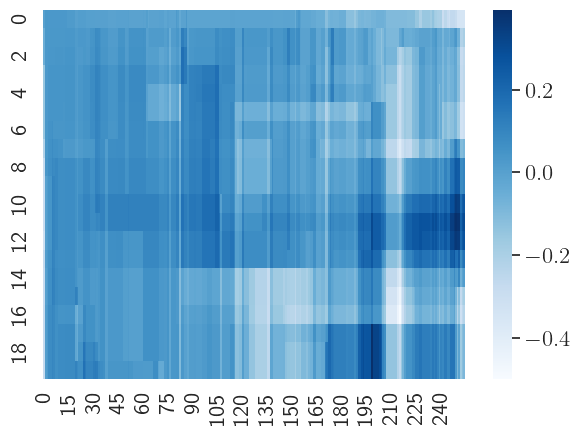

In [12]:
sns.heatmap(ilmart_model_distilled.hist[(feat1, feat2)][0:20, :],
            cmap="Blues",
            cbar_kws=dict(location="right", anchor=(0.5, .4), pad=0))